# Recurrent Neural Net Part 2

This notebook is based on a tutorial: "Multivariate Time Series using RNN with Keras" from [here](https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679)



## Meeting Agenda



1.   Project Updates

- Phil 
  - https://www.edx.org/bio/robert-van-de-geijn
  - Pink Zybo - board that executes Python on an FPGA - [pynq.io](https://pynq.io)

- Chuck - IBM Watson templates - learning Python

- J - RNN for soil moisture prediction

- Nick - Web app called "Improved Initiative" - manages attributes of D&D characters. Nick working on importing stat blocks.

- Phil - MDA Small Business Conference June 25-26

2.   SBIR Brainstorm Session Updates

 - MDA 19-005 Topic
 - MDA 19-011 Topic
 - Additional session to follow tonight
 
3.   RNN Code Walkthrough


## RNN Example Code

In [1]:
import numpy as np
import pandas as pd
import math
from keras import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


First, we download a csv export of the Google stock from [here](https://www.nasdaq.com/symbol/goog/historical).

For convenience, this is saved in the presentations repository and can be access by URL.

In [2]:
stock_data = pd.read_csv("https://github.com/HSV-AI/presentations/raw/master/2019/190619/HistoricalQuotes.csv")
stock_data.head(2)


,date,close,volume,open,high,low
0,16:00,"1,103.60","1,386,584","1,107.82","1,116.39","1,098.99"
1,2019/06/18,1103.6000,1386684.0000,1109.6900,1116.3900,1098.9900


In [3]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 6 columns):
date      1260 non-null object
close     1260 non-null object
volume    1260 non-null object
open      1260 non-null object
high      1260 non-null object
low       1260 non-null object
dtypes: object(6)
memory usage: 59.1+ KB


In [0]:
stock_data.high = (stock_data.high.str.split()).apply(lambda x: float(x[0].replace(',', '')))
stock_data.low = (stock_data.low.str.split()).apply(lambda x: float(x[0].replace(',', '')))
stock_data.volume = (stock_data.volume.str.split()).apply(lambda x: float(x[0].replace(',', '')))
stock_data.open = (stock_data.open.str.split()).apply(lambda x: float(x[0].replace(',', '')))


In [5]:

stock_data["average"] = (stock_data["high"] + stock_data["low"])/2
stock_data.head(2)


,date,close,volume,open,high,low,average
0,16:00,"1,103.60",1386584.0,1107.82,1116.39,1098.99,1107.69
1,2019/06/18,1103.6000,1386684.0,1109.69,1116.39,1098.99,1107.69


In [6]:
input_feature= stock_data.iloc[:,[2,6]].values
input_data = input_feature
input_feature.shape

output_feature = stock_data.iloc[:,3].values

print(input_feature.shape)
print(output_feature.shape)

(1260, 2)
(1260,)


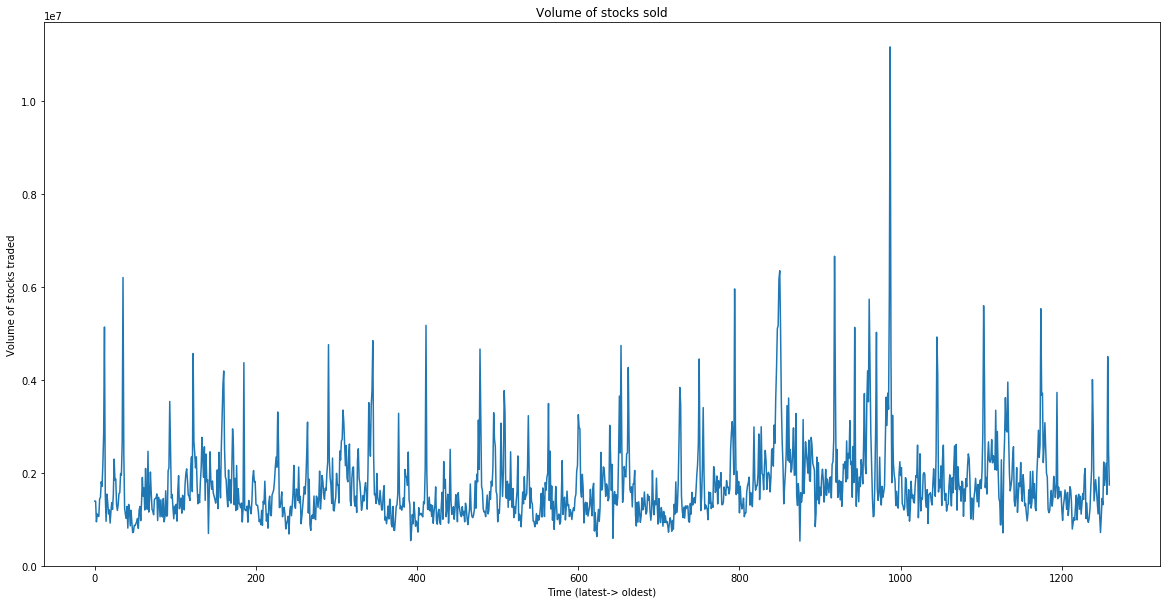

In [7]:
plt.figure(figsize=(20,10))
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

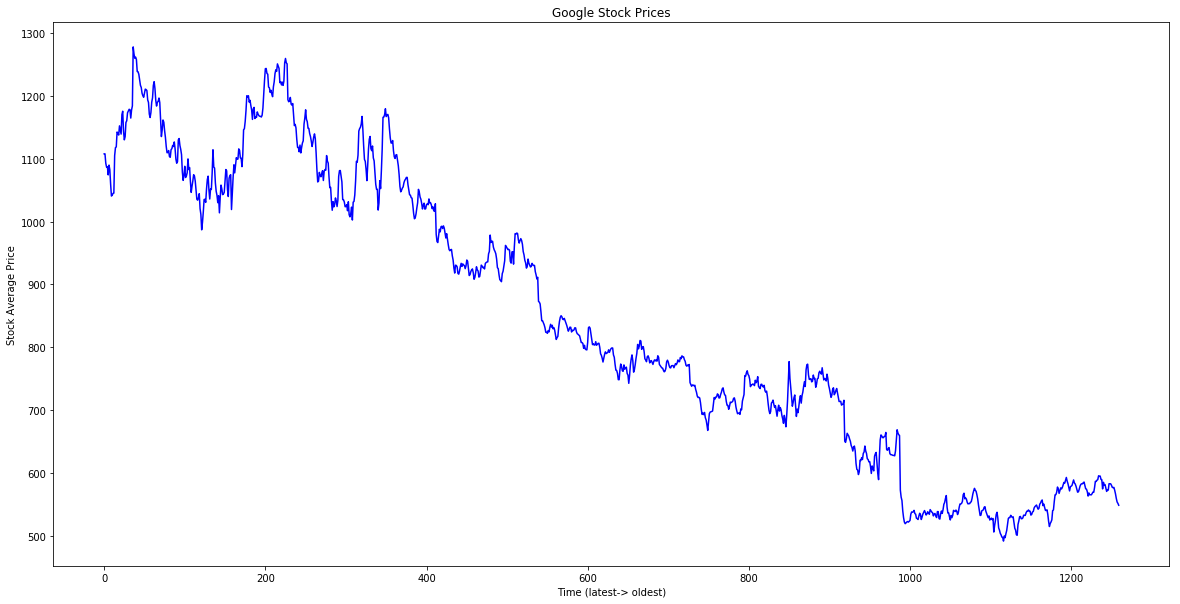

In [8]:
plt.figure(figsize=(20,10))
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Average Price")
plt.show()

In [0]:
input_scaler = MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = input_scaler.fit_transform(input_feature[:,:])

output_scaler = MinMaxScaler(feature_range=(0,1))
output_feature = output_feature.reshape(-1, 1)
output_data = output_scaler.fit_transform(output_feature)

In [0]:
lookback= 50

test_size=int(.3 * len(stock_data))
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])

    X.append(t)
    y.append(output_data[i+ lookback])

In [11]:
X, y= np.array(X), np.array(y)
X = X.reshape(X.shape[0],lookback, 2)
print(X.shape)
print(y.shape)

(1209, 50, 2)
(1209, 1)


In [12]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()


W0621 04:35:43.429358 139760205883264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 04:35:43.468783 139760205883264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 04:35:43.475865 139760205883264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            3960      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,631
Trainable params: 18,631
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

W0621 04:35:44.169739 139760205883264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



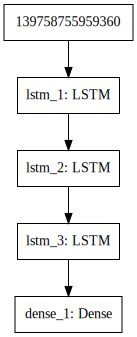

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
history = model.fit(X, y, validation_split=0.30, epochs=50, batch_size=32, verbose=1)



W0621 04:35:44.770342 139760205883264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0621 04:35:46.947868 139760205883264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0621 04:35:47.130833 139760205883264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 15s 18ms/step - loss: 0.0853 - val_loss: 0.0166
Epoch 2/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0098 - val_loss: 0.0117
Epoch 3/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 4/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/50
846/846 [==============================] - 9s 11ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 6/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 9/50
846/846 [==============================] - 9s 10ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 10/50
846/846 [=======================

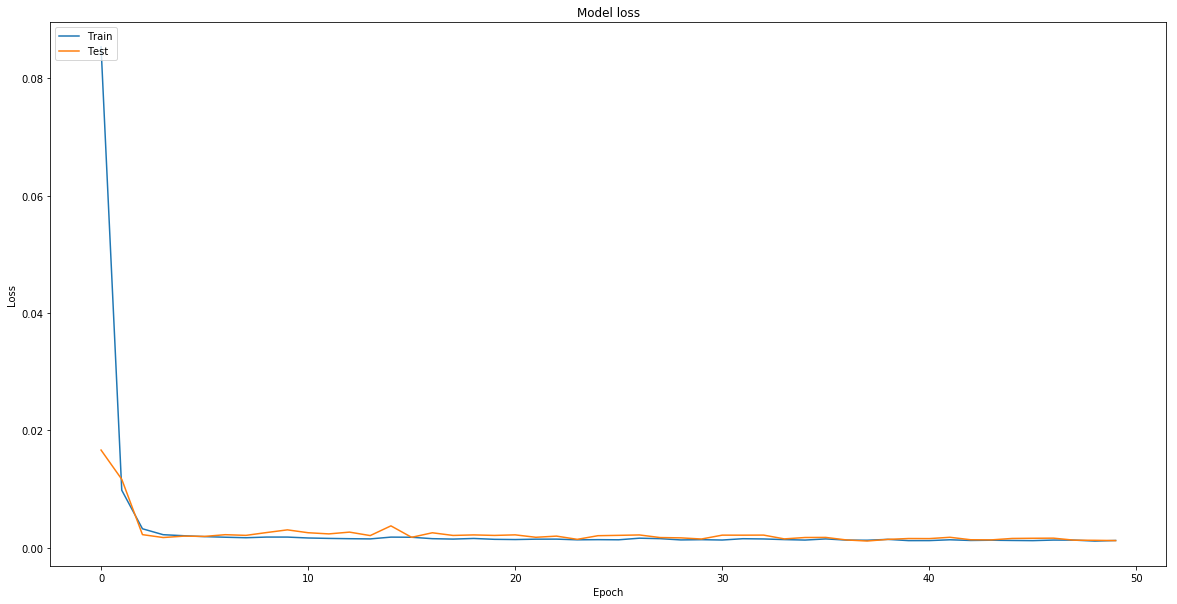

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [0]:
predicted_value = model.predict(X)
unscaled_output = output_scaler.inverse_transform(predicted_value)

temp = np.array(stock_data.open[lookback:-1]).reshape(-1,1)


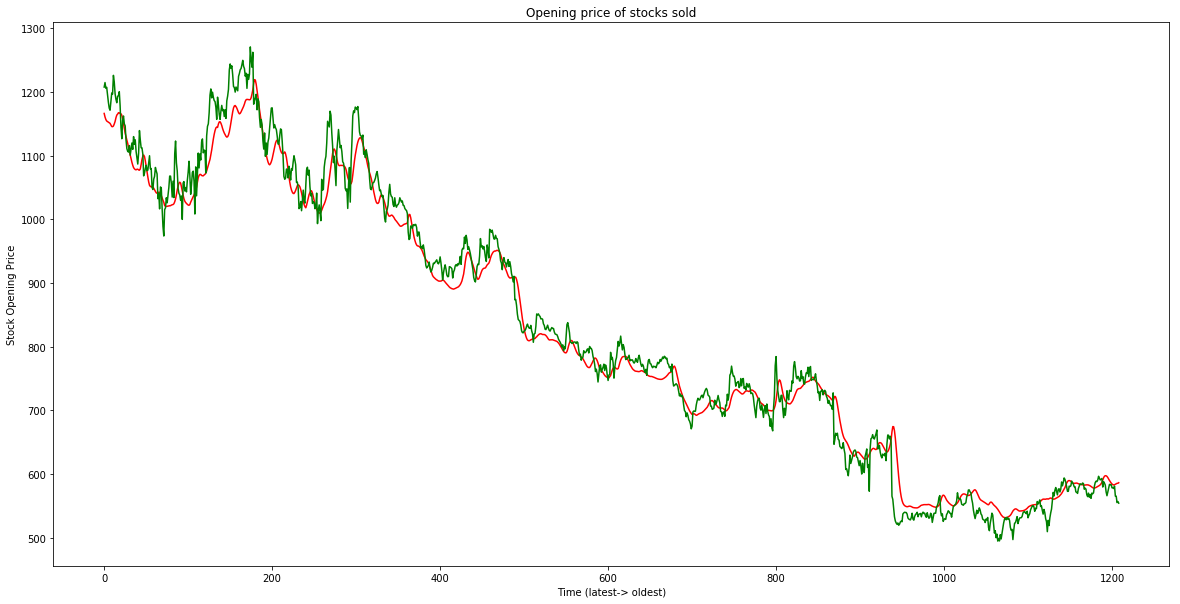

In [18]:

plt.figure(figsize=(20,10))
plt.plot(unscaled_output, color= 'red')
plt.plot(temp, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()